# Продуктовая аналитика
Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

**Описание данных**

- date – дата совершения события

- event - событие: \
        app_install – установка приложения 
        app_start – открыть приложения 
        registration – зарегистрироваться 
        search – перейти на страницу поиска товаров (каталог) 
        open_item – открыть товар 
        choose_item – отправить товар в корзину 
        tap_basket – перейти в корзину 
        purchase – подтверждение покупки 
    

- gender – пол пользователя

- os_name – платформа пользователя

- city – город пользователя

- device_id – идентификатор устройства пользователя

- urm_source – канал, с которого пришел пользователь:

        yandex-direct – Яндекс директ 
        google_ads – реклама в Google 
        vk_ads – реклама в ВК 
        instagram_ads – реклама в instagram 
        facebook_ads – реклама в facebook 
        referral – акция «приведи друга» 
        Если стоит ‘-’, то канал не определен или это скачивание приложения напрямую или посещение не с рекламы  

- purchase_sum – стоимость покупки (при совершении события ‘purchase’)

Обратите внимание на следующее:

- В выгрузке только уникальные действия пользователей за каждый день 

- Можно миновать стадию установки приложения, если оно было установлено ранее

- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

P.S. Графики должны быть интерактивными, но в гитхабе они не отображаются поэтому прикрепляю картинки

# Изучение исходных данных

In [404]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objects as go
from IPython.display import Image

import plotly.io as pio
pio.renderers.default = "notebook_connected"

pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [369]:
df = pd.read_csv(r'C:\Users\Honor\Downloads\KC_case_data1.csv')

In [370]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [371]:
df.dtypes

date             object
event            object
purchase_sum    float64
os_name          object
device_id         int64
gender           object
city             object
utm_source       object
dtype: object

In [372]:
df.shape

(2747968, 8)

In [373]:
df.isna().sum()

date                  0
event                 0
purchase_sum    2606585
os_name               0
device_id             0
gender                0
city                  0
utm_source            0
dtype: int64

In [374]:
#переведем столбец date к дейттайм типу и создадим колонку month
df['date'] = pd.to_datetime(df.date)
df['month'] = df.date.dt.month

**MAU за каждый месяц**

In [375]:
MAU = df.groupby('month', as_index=False).agg({'device_id':'nunique'}).rename(columns={'device_id':'MAU'})
MAU

,month,MAU
0,1,99161
1,2,75032
2,3,74623


In [376]:
px.bar(MAU, x='month', y='MAU', title='Monthly Active Users')

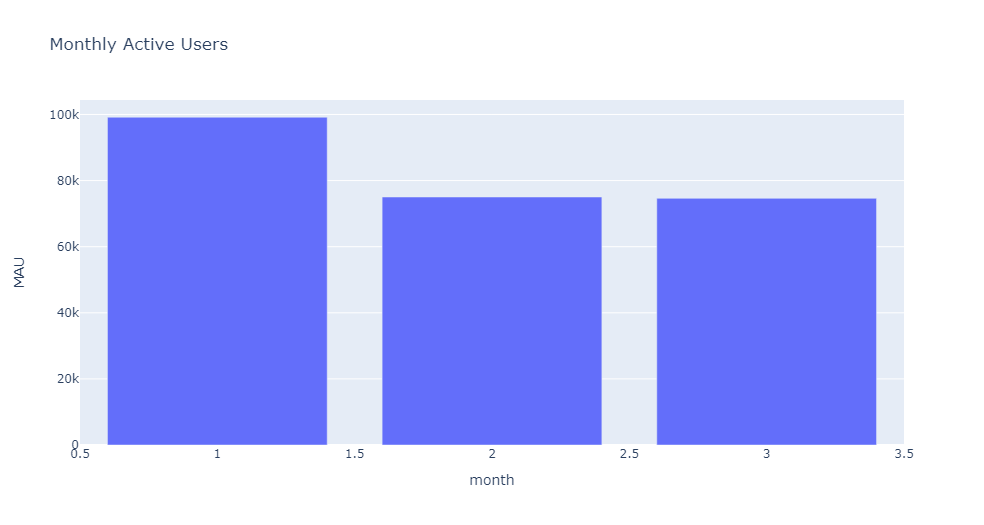

In [409]:
Image(r"C:\Users\Honor\Downloads\newplot4.png", width=1060, height=650) 

**Количество установок за каждый месяц**

In [377]:
inst = df.query('event == "app_install"').groupby('month', as_index=False) \
        .agg({'device_id':'nunique'}).rename(columns={'device_id':'installations'})
inst

,month,installations
0,1,80297
1,2,38078
2,3,36222


In [378]:
px.bar(inst, x='month', y='installations', title=' Number of Installations')

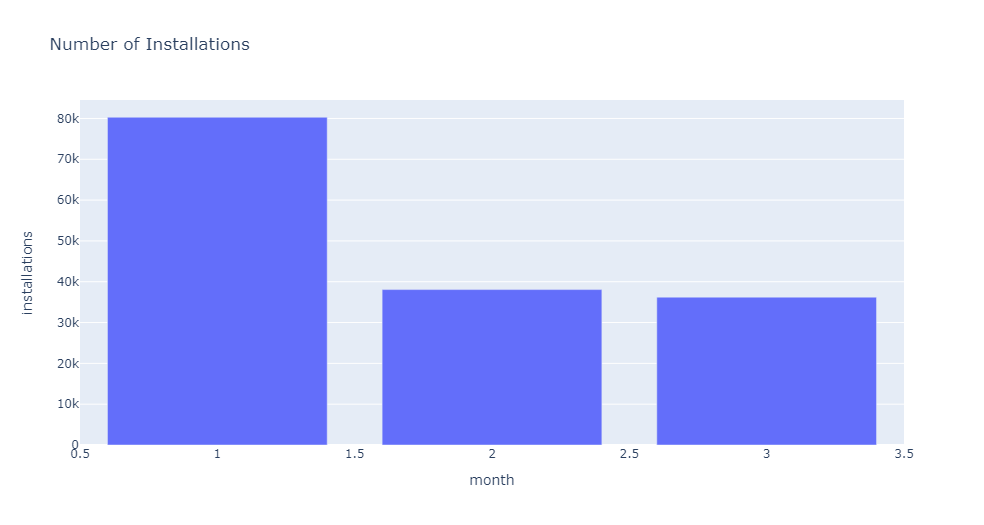

In [410]:
Image(r"C:\Users\Honor\Downloads\newplot5.png", width=1060, height=650) 

# Конверсия в течение 7 дней
Присвоим пользователям когорты по дню установки приложения и посчитаем для них  конверсию из установки в покупку в течение 7 дней.
Будем считать пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

In [379]:
#создадим таблицу seven_day_cr_df, в которой будут храниться данные о дате установки и первой покупке пользователя
df1 = df.query('event == "app_install"') \
        .groupby('device_id', as_index=False) \
        .agg({'date':'min'})
df2 = df.query('event == "purchase"') \
        .groupby('device_id', as_index=False) \
        .agg({'date':'min'})
seven_day_cr_df = df1.merge(df2, on = 'device_id', how='left').rename(columns=({'date_x':'installation_date', 'date_y':'first_purchase'}))

In [380]:
#считаем разницу в днях между датой первой покупки и установки
#если пользователь еще не совершал покупку, то ставим значение -1
seven_day_cr_df['diff'] = (seven_day_cr_df.first_purchase - seven_day_cr_df.installation_date).dt.days.fillna(-1)

In [381]:
seven_day_cr_df.head()

,device_id,installation_date,first_purchase,diff
0,4013,2020-01-15,NaT,-1.0
1,4016,2020-01-04,NaT,-1.0
2,4046,2020-01-04,2020-01-04,0.0
3,4065,2020-03-19,NaT,-1.0
4,4067,2020-01-31,NaT,-1.0


In [382]:
seven_day_cr_df['7day_conversion'] = seven_day_cr_df['diff'].apply(lambda x: 1 if x in range(0,8) else 0)
seven_day_cr_df = seven_day_cr_df.groupby('installation_date', as_index=False) \
    .agg({'7day_conversion':['sum','count']})
seven_day_cr_df['CR'] = seven_day_cr_df['7day_conversion']['sum']/seven_day_cr_df['7day_conversion']['count']
seven_day_cr_df[['installation_date', 'CR']].sort_values('CR', ascending=False).head(10)

,installation_date,CR
,,
0,2020-01-01,0.393406
8,2020-01-09,0.391854
14,2020-01-15,0.382831
13,2020-01-14,0.381403
1,2020-01-02,0.377226
12,2020-01-13,0.375191
18,2020-01-19,0.370846
19,2020-01-20,0.369576
15,2020-01-16,0.367514


Таким образом, мы посчитали конверсию 7 дней для когорт по дню установки приложения

In [383]:
df.groupby('utm_source', as_index=False) \
    .agg({'device_id':'nunique'}) \
    .sort_values('device_id', ascending=False)

,utm_source,device_id
0,-,52273
6,yandex-direct,40712
2,google_ads,38096
5,vk_ads,34086
3,instagram_ads,31048
1,facebook_ads,25959
4,referal,15926


# Анализ воронки
Проанализируем на каком этапе воронки отваливается бОльшая часть клиентов. Посмотрим отдельно сценарий для зарегистрированных пользователей. Узнаем на каком шаге отваливается больше всего пользователей.

**Зарегистрированные пользователи** \
Для того, чтобы выделить группу тех, кому нужно и не нужно регистрироваться, добавим колонку с датой регистрации. Если дата регистрации < даты совершения события, то пользователь уже зарегистрирован

In [384]:
df.event.unique()

array(['app_start', 'choose_item', 'purchase', 'search', 'tap_basket',
       'app_install', 'register'], dtype=object)

In [385]:
first_registration = df.query('event=="register"').sort_values('date').drop_duplicates('device_id')
df['first_registration'] = df.device_id.map(first_registration.set_index('device_id')['date'])

In [386]:
already_registered = df[df.first_registration < df.date]

In [387]:
funnel = already_registered.groupby('event', as_index=False) \
                    .agg({'device_id':'nunique'}) \
                    .rename(columns={'device_id':'number'})
funnel

,event,number
0,app_start,40991
1,choose_item,37926
2,purchase,24880
3,search,40482
4,tap_basket,34517


In [388]:
flow_count = [funnel.number[0], funnel.number[3], funnel.number[1], funnel.number[4], funnel.number[2]]
flow_count
stages = ['app_start','search','choose_item','tap_basket', 'purchase']

In [389]:
fig = go.Figure(go.Funnel( x=flow_count, y=stages , textinfo = "value+percent initial"))
fig.show()

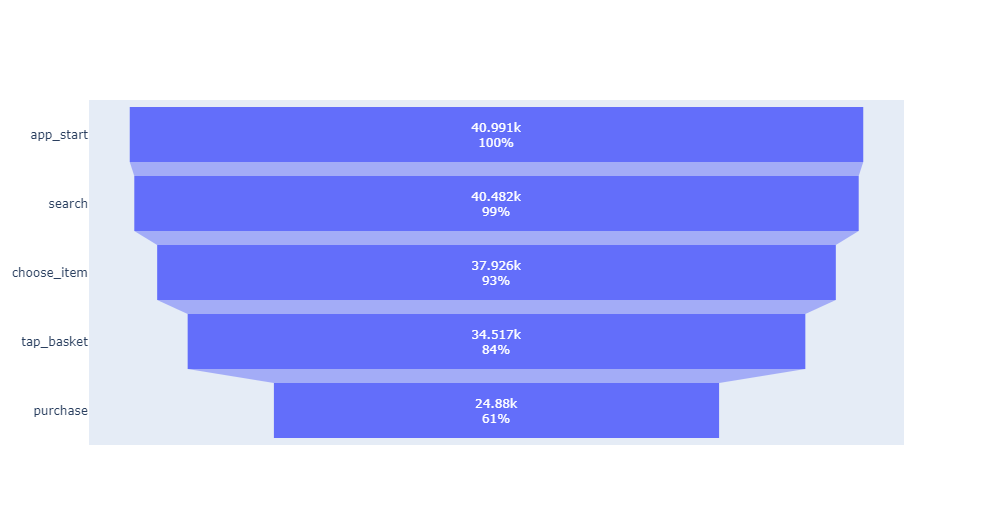

In [411]:
Image(r"C:\Users\Honor\Downloads\newplot6.png", width=1060, height=650) 

Среди зарегистрированных пользователей наибольшая часть отваливается при переходе **из корзины к покупке** 

# Анализ маркетинговых каналов
Посмотрим на пользователей в разбивке по каналам, узнаем какие из них показали самую низкую конверсию в первую покупку. \
Также посмотрим на размеры чеков пользователей, пришедших с разных каналов. \
Посчитаем какой из каналов имеет самый высокий ROMI.

In [390]:
first_app_start = df.query('event=="app_start"').sort_values('date').drop_duplicates('device_id')
df['first_app_start'] = df.device_id.map(first_registration.set_index('device_id')['date']).fillna(0)

In [391]:
first_purchase = df.query('event=="purchase"').sort_values('date').drop_duplicates('device_id')
df['first_purchase'] = df.device_id.map(first_registration.set_index('device_id')['date']).fillna(0)

In [392]:
df['converted'] = df.first_purchase.apply(lambda x: 1 if x!=0 else 0)

In [393]:
cr_df = df.groupby('utm_source', as_index=False) \
    .agg({'first_app_start':'count', 'converted':'sum'})

In [394]:
cr_df['CR'] = cr_df.converted/cr_df.first_app_start

In [395]:
cr_df.sort_values('CR')

,utm_source,first_app_start,converted,CR
6,yandex-direct,390232,294593,0.754918
2,google_ads,374257,284322,0.759697
0,-,610458,484649,0.793910
3,instagram_ads,382891,314244,0.820714
1,facebook_ads,336953,278850,0.827563
5,vk_ads,418456,346350,0.827686
4,referal,234721,202958,0.864678


Самую низкую конверсию в первую покупку показали **Яндекс и Гугл (75.49% и 75.97%)**

In [396]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,first_registration,first_app_start,first_purchase,converted
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,1,2020-01-07,2020-01-07 00:00:00,2020-01-07 00:00:00,1
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,1,2020-01-01,2020-01-01 00:00:00,2020-01-01 00:00:00,1
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,1,2020-01-01,2020-01-01 00:00:00,2020-01-01 00:00:00,1
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,1,2020-01-01,2020-01-01 00:00:00,2020-01-01 00:00:00,1
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,1,NaT,0,0,0


In [397]:
first_purchase = df.query('event=="purchase"').sort_values('date').drop_duplicates('device_id')
first_purchase.groupby('utm_source', as_index=False) \
                .agg({'purchase_sum':'mean'}) \
                .sort_values('purchase_sum')

,utm_source,purchase_sum
1,facebook_ads,692.090029
4,referal,696.420128
0,-,698.211078
2,google_ads,700.920134
3,instagram_ads,716.201018
5,vk_ads,716.480192
6,yandex-direct,725.740719


Пользователи с наименьшим средним первым чеком (учитываются только первые покупки) пришли из Фейсбука \
А наибольший средний первый чек можно наблюдать среди юзеров, пришедших из Яндекса

**Данные по затратам на рекламу:**

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

Расходы на реферальную программу: если пользователь приведет друга и последний совершит первую покупку, то оба получат по 100 рублей.

In [398]:
marketing = [8590498, 10534878, 8561626, 9533531, 10491707]
yandex = 10491707
google = 10534878
facebook = 8590498
instagram = 8561626
vk = 9533531

In [399]:
romi = df.groupby('utm_source', as_index=False) \
    .agg({'purchase_sum':'sum'}).query('utm_source!="-" & utm_source!="referal"')

In [400]:
romi['exspenses'] = marketing

In [401]:
romi['romi'] = (romi.purchase_sum - romi.exspenses)/romi.purchase_sum

In [402]:
romi.sort_values('romi')

,utm_source,purchase_sum,exspenses,romi
2,google_ads,12868276.0,10534878,0.181329
6,yandex-direct,13915368.0,10491707,0.246035
1,facebook_ads,12249901.0,8590498,0.298729
3,instagram_ads,14546969.0,8561626,0.411449
5,vk_ads,16389652.5,9533531,0.418320


In [403]:
referal = first_purchase.query('utm_source=="referal"').sort_values('date').drop_duplicates('device_id').converted.sum()*200
revenue = df.query('utm_source=="referal"').purchase_sum.sum()
referal_romi = (revenue-referal)/revenue
referal_romi

0.8686664981714192

Самый высокий ROMI у реферальной программы 86.87% \
Канал с самым низким ROMI - Гугл (18.13%)